# Neurons with Dendritic Trees
Author: Christian Pehle



In [4]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.base.tree_solver import tree_solve, tree_matmul
from jaxsnn.base.types import ArrayLike

import matplotlib.pyplot as plt

In [5]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike

    def explicit_terms(self, state):
        return NeuronState(v=state.I, I=-20 * state.I)

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), I=np.zeros_like(state.I)
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )

In [13]:
N = 5
dt = 1e-2
inner_steps = 1
outer_steps = 2048
time = dt * inner_steps * (1 + np.arange(outer_steps))


equation = MultiCompartmentNeuronModel(
    d=-2 * np.ones(N), u=np.ones(N - 1), p=np.arange(-1, N, 1)
)

semi_implicit_step = implicit.imex_rk_sil3(equation, dt)
integrator = funcutils.trajectory(
    funcutils.repeated(semi_implicit_step, inner_steps), outer_steps
)

actual_v = [] # [np.zeros((N,outer_steps))]
for idx in range(N):
    initial_state = NeuronState(
        v=np.zeros(N), I=np.concatenate((np.eye(5)[idx], np.zeros(N - 5)))
    )
    _, actual = integrator(initial_state)
    actual_v.append(actual.v)

actual_v = np.stack(actual_v)

ValueError: All input arrays must have the same shape.

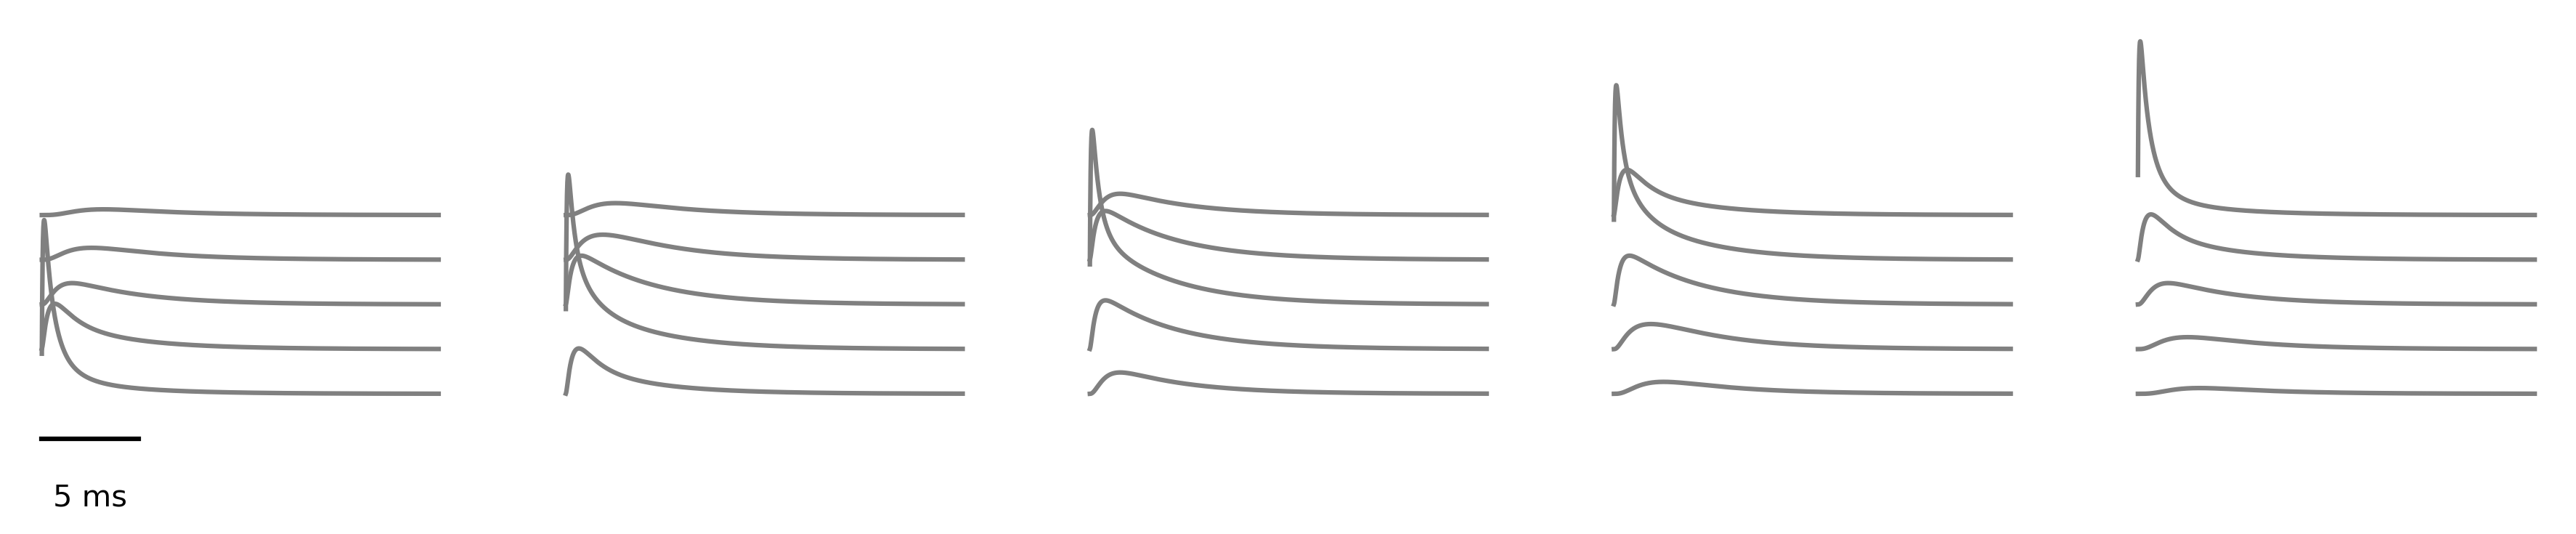

In [11]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(
    1,
    5,
    sharex=True,
    figsize=(3 * 5, 3 * 5),
    sharey=True,
    subplot_kw=dict(box_aspect=1),
    dpi=300,
)
for idx in range(N):
    for site in range(5):
        ax[site].plot(time, actual_v[idx][:, site] + 0.01 * idx, color="grey")
        ax[site].set_axis_off()

ax[0].plot([0, 5], [-0.01, -0.01], color="black")
ax[0].text(2.5, -0.02, "5 ms", ha="center", va="top")

plt.savefig("passive_cable.png", bbox_inches="tight")

In [48]:
import jax.numpy as jnp
import numpy as onp
import jax


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitCDE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike

    def explicit_terms(self, state, u):
        return NeuronState(v=state.I, I=-20 * state.I + u.I)

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), I=np.zeros_like(state.I)
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )


@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike


def input_integrator(stim):
    N = 5
    dt = 1e-2
    inner_steps = 1
    outer_steps = 2000
    time = dt * inner_steps * (1 + np.arange(outer_steps))
    equation = MultiCompartmentNeuronModel(
        d=-2 * np.ones(N), u=np.ones(N - 1), p=np.arange(-1, N, 1)
    )

    semi_implicit_step = implicit.imex_rk_sil3_cde(equation, dt)
    integrator = funcutils.controlled_trajectory(semi_implicit_step, stim)
    initial_state = NeuronState(v=np.zeros(N), I=np.zeros(N))
    _, actual = integrator(initial_state)
    return actual.v[-1][-1]


T = 2048
dt = 0.1
stim = onp.zeros((T, 1))
stim[0, 0] = 1.0 / dt  # add a delta pulse
time = dt * (1 + np.arange(T))

stim = NeuronState(v=np.zeros((T, 5)), I=np.zeros((T, 5)))

fn = jax.value_and_grad(input_integrator)
out, grad = fn(stim)

NameError: name 'actual_v' is not defined

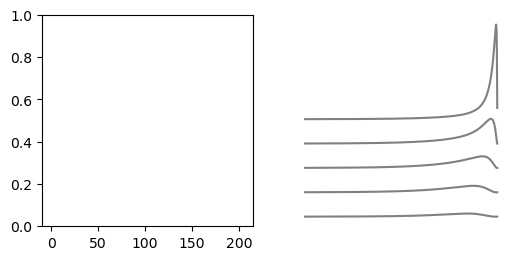

: 

In [ ]:
fig, ax = plt.subplots(
    1,
    2,
    sharex=True,
    figsize=(3 * 2, 3 * 2),
    subplot_kw=dict(box_aspect=1),
)

for i in range(5):
    ax[1].plot(time, grad.I[:, i] + 0.0001 * i, color="grey")
    ax[1].set_axis_off()

for i in range(5):
    ax[0].plot(time, actual_v[-1][:, i] + 0.01 * i, color="grey")
    ax[0].set_axis_off()

In [40]:
a = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
    ]
)
b = np.arange(1, 9)
parents = np.matmul(a, b)

In [30]:
np.diag(np.sum(a + a.T, axis=0)) - (a + a.T)

Array([[ 1, -1,  0,  0,  0,  0,  0,  0],
       [-1,  3, -1,  0,  0, -1,  0,  0],
       [ 0, -1,  3, -1, -1,  0,  0,  0],
       [ 0,  0, -1,  1,  0,  0,  0,  0],
       [ 0,  0, -1,  0,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  3, -1, -1],
       [ 0,  0,  0,  0,  0, -1,  1,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  1]], dtype=int32)

In [31]:
@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    m: ArrayLike

    def explicit_terms(self, state):
        return NeuronState(v=state.I, I=-20 * state.I)

    def implicit_terms(self, state):
        return NeuronState(v=np.matmul(self.m, state.v), I=np.zeros_like(state.I))

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )

In [32]:
def coupling_matrix(G_m, D_s, G_a, A, D_i):
    """ "
    Parameters:
        G_m: membrane conductance
        G_a: axial conductance
        D_s: diagonal matrix of compartment surfaces
        D_i: diagonal matrix of inverse volumes
        A  : adjacency matrix
    """
    m = np.matmul(A, D_i) + np.matmul(D_i, A.T)
    M = G_a * (np.diag(np.sum(m)) - m) + G_m * D_s
    return M

Instead of involving the geometry of the neuron (such as the surface and inverse volumes) we can instead use abstract conductances. This simplifies the implementation of the coupling matrix to

In [33]:
def coupling_matrix(G, G_m):
    """ "
    Parameters:
        G   : coupling conductances
        G_m : membrane coupling conductances (typically dynamic)
    """
    m = G + G.T
    laplace = np.diag(np.sum(m, axis=0)) - m
    return laplace + np.diag(G_m)

## Modelling Networks of Multi-Compartment Neurons

If the resolution of the multicompartment neuron is chosen high enough, the synaptic coupling matrix $W$ will have at most one non-zero entry per column, which indicates which pre-synaptic neuron compartment is connected to which post-synaptic neuron compartment. The overall matrix multiplication is fully implemented by the physical structure of the neuron.

In [17]:
from typing import Callable


@tree_math.struct
class NeuronState:
    v: ArrayLike
    s: ArrayLike  # synaptic gating


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    # conductance based coupling within neuron
    m: ArrayLike
    # coupling between neurons
    w: ArrayLike

    # synapse gating mechanism
    tau_s_inv: ArrayLike
    gating_function: Callable

    def explicit_terms(self, state):
        I_s = np.matmul(self.w, state.s)
        I_c = np.matmul(self.m, state.v)
        v_dot = I_s + I_c
        return NeuronState(
            v=I_s, s=self.tau_s_inv * (-state.s + self.gating_function(state.v) * v_dot)
        )

    def implicit_terms(self, state):
        return NeuronState(v=np.matmul(self.m, state.v), s=np.zeros_like(state.s))

    def implicit_solve(self, state, step_size):
        N = state.v.shape[0]
        return NeuronState(
            v=np.linalg.solve(np.eye(N) - step_size * self.m, state.v), s=state.s
        )

We are interested in jump conditions, which can be written as
$$
P x + b
$$
with P a projection matrix and b some constant function. The linearisation in time is given by
$$
P \dot{x}
$$
We can also consider the case of solving for roots independently
$$
(P_0 x_0 + b_0, \ldots, P_N x_N + b_N)
$$
in this case the linearisation is
$$
(P_0 \dot{x}_0, \ldots, P_N \dot{x}_N)
$$
either way

Branching chain with four compartments in each chain